# Intro

This is a very interesting problem in which we have not 1 but over 3600 time-series models to forecast. Each model is different in its own way but similar in overall bahaviour of seasonality and trend. <br>

Following activities are done on the data (each activity is described detail in the following sections): 
* Data cleaning, transformation, engineering, filling the missing values, etc
* Exploratory data analysis (EDA) is done to visualize trend and seasonality of sample time-series models and also combination of all the time-series models. 
* Mutliple exciting models are planned to forecast such as 
    * SARIMAX
    * Vector Auto regression
    * Multi linear regression with ARIMA
    * Ensemble of above models

But in v1, I've used only SARIMAX which performed good-enough for a starter.<br>
Official error evaluation metric is WMAE (weighted mean absolute error) <br>

Following are the results:

* Validation error (train-test-split=0.7:0.3) is 2683 
* Submission error is 3207 (Top 35%)(Total 690 submissions)
* Note: For comarision 1st rank submission error is 2300.

<br>

Future activities to be done on this problem:
* Try above mentioned intended models.
* Use grid search to find better ARIMA parameters
* 


In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling 
import math
import numpy as np
import gc
from pandas.api.types import CategoricalDtype
from scipy.special import boxcox1p
%matplotlib inline
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
sns.set(rc={'figure.figsize':(11.7,8.27)})
import warnings
warnings.filterwarnings(action='once')

/kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv
/kaggle/input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv.zip


In [2]:
import zipfile
zip_paths = ['/kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv.zip','/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv.zip','/kaggle/input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip','/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip']
directory_to_extract_to = '/kaggle/working'
for path_to_zip_file in zip_paths:
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)

In [3]:
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/working/train.csv
/kaggle/working/sampleSubmission.csv
/kaggle/working/test.csv
/kaggle/working/features.csv
/kaggle/working/__notebook__.ipynb


In [4]:
rtrain = pd.DataFrame(pd.read_csv('/kaggle/working/train.csv',parse_dates=[2],index_col=2,squeeze=True))
rfeatures = pd.DataFrame(pd.read_csv('/kaggle/working/features.csv',parse_dates=[1],index_col=1,squeeze=True))
rtest = pd.DataFrame(pd.read_csv('/kaggle/working/test.csv',parse_dates=[2],index_col=2,squeeze=True))
rstore = pd.DataFrame(pd.read_csv('/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv'))

In [5]:
rtrain

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False
...,...,...,...,...
2012-09-28,45,98,508.37,False
2012-10-05,45,98,628.10,False
2012-10-12,45,98,1061.02,False


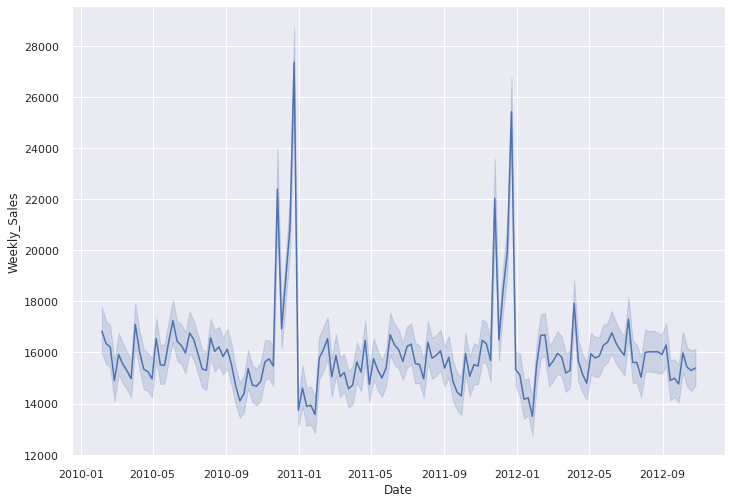

In [6]:
# plot all the sales at once
sns.lineplot(data=rtrain,x=rtrain.index, y="Weekly_Sales")

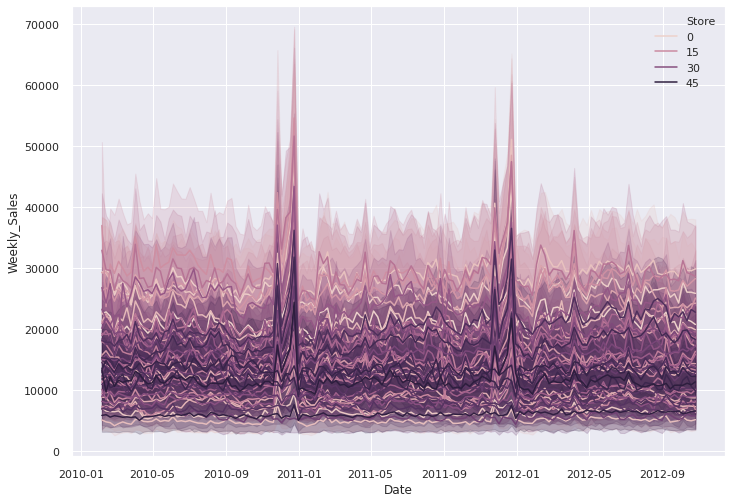

In [7]:
# following takes awefull amount of time and very unclear to see proper patterns. so we plot just a slice of it in below cell.
sns.lineplot(data=rtrain,x=rtrain.index, y="Weekly_Sales",hue="Store")

In [8]:
storeid = [val*5 for val in range(1,10)]
tmp_rtrain = pd.DataFrame(rtrain.loc[rtrain['Store'].isin(storeid)])
tmp_rtrain['Store'].unique()

array([ 5, 10, 15, 20, 25, 30, 35, 40, 45])

below is plot001

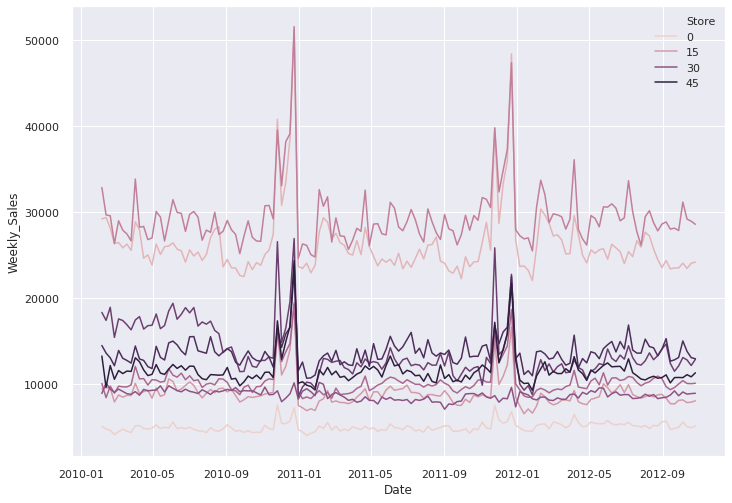

In [9]:
# we plot weekly sales of above stores to look in depth
sns.lineplot(data=tmp_rtrain,x=tmp_rtrain.index, y="Weekly_Sales",hue="Store",ci=None)

In [10]:
tmp_rtrain = pd.DataFrame(rtrain.loc[rtrain['Store']==1])
tmp_rtrain['Store'].unique()                          

array([1])

below is plot002

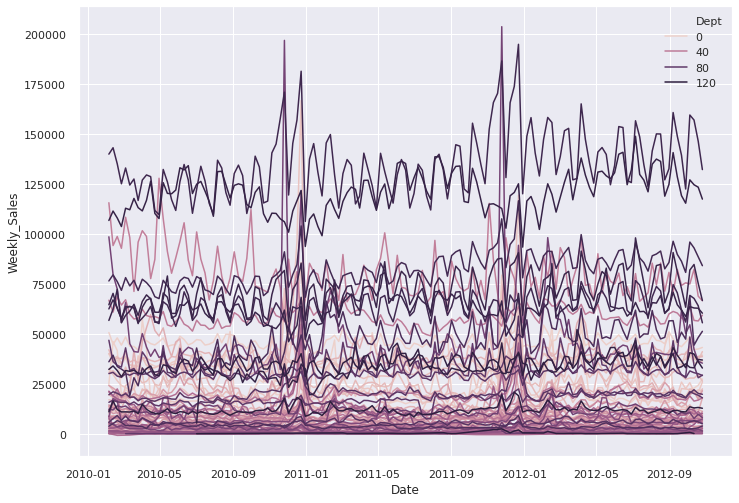

In [11]:
sns.lineplot(data=tmp_rtrain,x=tmp_rtrain.index, y="Weekly_Sales",hue="Dept",ci=None)

[2]


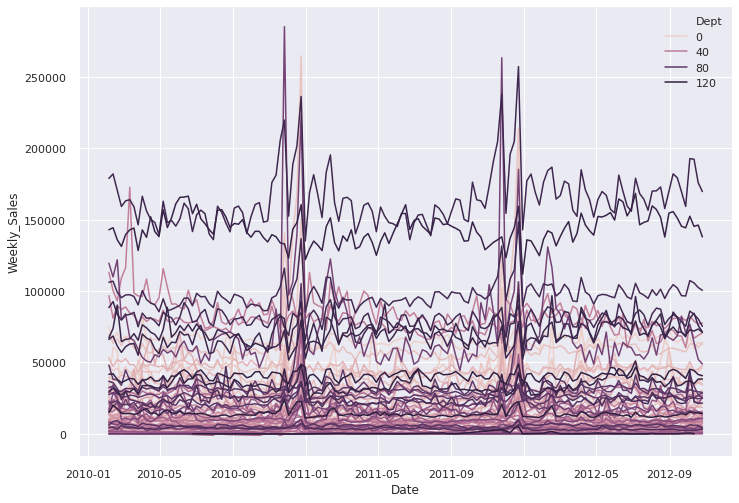

In [12]:
tmp_rtrain = pd.DataFrame(rtrain.loc[rtrain['Store']==2])
print (tmp_rtrain['Store'].unique())
sns.lineplot(data=tmp_rtrain,x=tmp_rtrain.index, y="Weekly_Sales",hue="Dept",ci=None)

In [13]:
storeid = rtrain['Store'].unique()
print (len(storeid))
print (len(rtrain['Dept'].unique()))
print (45*81)

45
81
3645


# Prelim analysis 

* Given 2 years of train data and we need to forecast for 1 year of test data.
* data is weekly
* Each store, dept pair has 124 weeks of data. 

main points
1. "Weekly_sales" has No trend
2. "Weekly_sales" has strong Seasonality at year end
3. Each store has different timeseries (evident from plot001)
    * so we timeseries model for each store (Total 45 store)
4. Each dept in a perticular store has different timeseries (see plot002)
    * so we should have timeseries model for each dept (Total 3645 depts = 45 store * 81 dept per store)
5. 

In [14]:
# utilities class 
class Utils:
    @classmethod
    def check_holiday_same(cls, rtrain_orig, rfeatures_orig, storeid):
        '''
        This checks the IsHoliday feature of training data is same as IsHoliday feature of features data
        '''
        rtrain = rtrain_orig.copy()
        rfeatures = rfeatures_orig.copy()
        tmp_rf = rfeatures.loc[rfeatures['Store']==storeid]
        tmp_df = rtrain.loc[(rtrain['Store']==storeid) & (rtrain['Dept']==1)]
        tmp_df = tmp_df.rename(columns={'IsHoliday':'storeHoliday'})
        tmp_df2 = pd.merge(tmp_df,tmp_rf, left_index=True,right_index=True)
        val = tmp_df2['storeHoliday'].equals(tmp_df2['IsHoliday'])
        return val
    
    @classmethod
    def missing_vals(cls, indf, id_str=None):
        if (id_str is None):
            id_str = 'Id'
        countdf = indf.count()
        missdict = {}
        for key,val in countdf.items():
            missdict[key] = countdf[id_str] - val
        missdf = pd.DataFrame(missdict.items(),columns=['name','miss_val'])
        miss_pct = pd.DataFrame((missdf['miss_val']/countdf[id_str])*100)
        miss_pct = miss_pct.rename(columns={'miss_val':'miss_pct'})
        missdf = pd.concat([missdf,miss_pct],axis=1,join='inner')
        missdf = missdf.sort_values(by='miss_pct',ascending=False)
        return missdf
    
    @classmethod
    def apply_boxcox1p(cls, indf, collist,lmd):
        temp = indf.copy()
        df = pd.DataFrame(boxcox1p(temp[collist],lmd))
        temp = temp.drop(columns=collist,axis=1)
        outdf = pd.concat([temp,df],join="inner",axis=1)
        return outdf
    
    @classmethod
    def get_dummies(cls, indf, collist):
        tmp = indf.copy()
        for col in collist:
            dummy = pd.get_dummies(indf[col],prefix=col)
            tmp = pd.concat([tmp, dummy],axis=1,join='inner')
            tmp.drop(columns=[col],axis=1,inplace=True)
        return tmp

# Data preprocessing conclusion 

* Drop IsHoliday column from features df, As that column is same as IsHoliday of train data.
* Merged features data with train data (merge on Date, storeid)
* Merged store data with train data (merge on storeid)
* Transformed IsHoliday of train/test data into 1/0 and nothing else to transform in test data.
* As Markdown1-5 missing rate is more than 65% and we have lot to do. Lets drop them and continue modelling. Once we complete without Markdown, we add if it requires.
* rtest[rtest['CPI'].isnull()].head(40) tells us that in every (store, dept) some equal percent of values are missing in 'CPI', 'Unemployment'. so we are filling those missing values as avg of rest of the rows in each of (store, dept)
* apply boxcox1p(0) transformation on ['Weekly_Sales','Temperature','CPI','Unemployment','Size'] of train/test data to remove heteroscedasticity.
* change Type (A/B) to Type (1/0) in both train/test data.
* check np.inf -np.inf in data and replace it with NaN
    * In train data, some weekly_sales records became NaN. So i'm just dropping them because i can't do anything about the result. can i?
    * In train/test data, we got some Temp as NaN.
        * In train data, We got NaN for (store 7) on "2011-02-04" only. So we are replacing the temp on "2011-02-11" (next week) of the store 7.
        * In test data, we got null temp on 13-01-04 (d1), 13-01-11(d2),13-01-18 (d3) at store 7. so we are replacing them with nearby temp of store 7.
* check value consistency across all the features
    * [Not done as sales can be -ve] In train data, some Weekly_Sales are -ve. so make them 0
        * [improvement_1] all these (Weekly_Sales=0) is skewed. so if we can remove them. it would be better than using them.
    * All test data is good.


**Now the data is in correct form to model.**


In [15]:
# check whether IsHoliday in features.csv is duplicate of IsHoliday in train data.
tmp_list = [Utils.check_holiday_same(rtrain, rfeatures, sid) for sid in range(1,46)]
'False' in tmp_list

False

So we can drop IsHoliday from features data

In [16]:
rfeatures.drop(columns='IsHoliday', inplace=True, axis=1)

In [17]:
# we should combine features data, store data, into train and test data.
# merge with index and column is not working. so we are pulling index and making a column and 
# then merging with two columns (data, store)

temp_train = rtrain.copy()
temp_test = rtest.copy()
temp_feat = rfeatures.copy()
temp_train['Date_col'] = temp_train.index
temp_feat['Date_col'] = temp_feat.index
temp_test['Date_col'] = temp_test.index

temp_train = temp_train.merge(temp_feat,how='left')
temp_test = temp_test.merge(temp_feat,how='left')

temp_train = pd.merge(temp_train,rstore, on=['Store'])
temp_test = pd.merge(temp_test,rstore, on=['Store'])

temp_train.rename(columns={'Date_col':'Date'},inplace=True)
temp_train.index = temp_train['Date']
temp_train.drop('Date',axis=1,inplace=True)

temp_test.rename(columns={'Date_col':'Date'},inplace=True)
temp_test.index = temp_test['Date']
temp_test.drop('Date',axis=1,inplace=True)

rtrain = temp_train
rtest = temp_test


In [18]:
del temp_train
del temp_test
# del rfeatures
# del rstore

gc.collect()

30

In [19]:
rtrain.loc[rtrain.IsHoliday == True,'IsHoliday'] =1 
rtrain.loc[rtrain.IsHoliday == False,'IsHoliday'] =0

rtest.loc[rtest.IsHoliday == True,'IsHoliday'] =1 
rtest.loc[rtest.IsHoliday == False,'IsHoliday'] =0

In [20]:
# lets check missing values of train, test

miss_train = Utils.missing_vals(rtrain,"Store")
miss_test = Utils.missing_vals(rtest,"Store")

In [21]:
miss_train

,name,miss_val,miss_pct
7,MarkDown2,310322,73.611025
9,MarkDown4,286603,67.984676
8,MarkDown3,284479,67.480845
6,MarkDown1,270889,64.257181
10,MarkDown5,270138,64.079038
0,Store,0,0.000000
1,Dept,0,0.000000
2,Weekly_Sales,0,0.000000
3,IsHoliday,0,0.000000
4,Temperature,0,0.000000


In [22]:
miss_test

,name,miss_val,miss_pct
10,CPI,38162,33.165890
11,Unemployment,38162,33.165890
6,MarkDown2,28627,24.879198
8,MarkDown4,12888,11.200723
7,MarkDown3,9829,8.542203
5,MarkDown1,149,0.129493
0,Store,0,0.000000
1,Dept,0,0.000000
2,IsHoliday,0,0.000000
3,Temperature,0,0.000000


In [23]:
dp_list = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
rtrain.drop(columns=dp_list, axis=1,inplace=True)
rtest.drop(columns=dp_list, axis=1,inplace=True)

In [24]:
rtest

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
Date,,,,,,,,,
2012-11-02,1,1,0,55.32,3.386,223.462779,6.573,A,151315
2012-11-09,1,1,0,61.24,3.314,223.481307,6.573,A,151315
2012-11-16,1,1,0,52.92,3.252,223.512911,6.573,A,151315
2012-11-23,1,1,1,56.23,3.211,223.561947,6.573,A,151315
2012-11-30,1,1,0,52.34,3.207,223.610984,6.573,A,151315
...,...,...,...,...,...,...,...,...,...
2013-06-28,45,98,0,76.05,3.639,NaN,NaN,B,118221
2013-07-05,45,98,0,77.50,3.614,NaN,NaN,B,118221
2013-07-12,45,98,0,79.37,3.614,NaN,NaN,B,118221


In [25]:
# rtest[rtest['CPI'].isnull()].head(40) tells us that in every (store, dept) some equal percent of 
# values are missing in 'CPI' and in 'Unemployment'.
# so we are filling those missing values as avg of rest of the rows in each of (store, dept)

itr_gp = pd.DataFrame(rtest.groupby(['Store','Dept']))
tmp_gp = rtest.groupby(['Store','Dept'])
# ttmp = tmp_gp.get_group((1,1)).mean()

pd.set_option('mode.chained_assignment', None)

for row in itr_gp[0]:
    storeid = row[0]
    deptid = row[1]
    ttmp = tmp_gp.get_group((storeid,deptid)).mean()
    cpival = ttmp['CPI']
    unemp = ttmp['Unemployment']
    rtest.loc[(rtest.Store == storeid) & (rtest.Dept==deptid) & (rtest.CPI.isnull()), 'CPI'] = cpival
    rtest.loc[(rtest.Store == storeid) & (rtest.Dept==deptid) & (rtest.Unemployment.isnull()), 'Unemployment'] = unemp

pd.set_option('mode.chained_assignment', 'raise')

In [26]:
miss_test = Utils.missing_vals(rtest,"Store")
miss_test

,name,miss_val,miss_pct
5,CPI,53,0.046061
6,Unemployment,53,0.046061
0,Store,0,0.000000
1,Dept,0,0.000000
2,IsHoliday,0,0.000000
3,Temperature,0,0.000000
4,Fuel_Price,0,0.000000
7,Type,0,0.000000
8,Size,0,0.000000


In [27]:
rtest[(rtest['Store']==4) & (rtest['Dept']==39)]

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
Date,,,,,,,,,
2013-07-12,4,39,0,82.3,3.368,NaN,NaN,A,205863


All those records whose CPI is still NaN, are those which didn't have values other than NaN. <br>
so lets fill all those NaN's with their store avg values.

In [28]:
tmp_gp2 = rtest.groupby(['Store'])
for row in itr_gp[0]:
    storeid = row[0]
    deptid = row[1]
    ttmp = tmp_gp2.get_group(storeid).mean()
    cpival = ttmp['CPI']
    unemp = ttmp['Unemployment']
    rtest.loc[(rtest.Store == storeid)  & (rtest.CPI.isnull()), 'CPI'] = cpival
    rtest.loc[(rtest.Store == storeid) & (rtest.Unemployment.isnull()), 'Unemployment'] = unemp


In [29]:
# to remove heteroscedasticity, we should apply log transformation. 
collist = ['Weekly_Sales','Temperature','CPI','Unemployment','Size']
rtrain = Utils.apply_boxcox1p(rtrain,collist,0)
collist = ['Temperature','CPI','Unemployment','Size']
rtest = Utils.apply_boxcox1p(rtest,collist,0)

In [30]:
rtrain = Utils.get_dummies(rtrain, ['Type'])
rtest = Utils.get_dummies(rtest, ['Type'])

In [31]:
rtrain.replace([np.inf,-np.inf],np.nan,inplace=True)
rtest.replace([np.inf,-np.inf],np.nan,inplace=True)

In [32]:
# checked where, when temp is null then changing accordingly.
# droping all the NaNs for weekly_sales
# tmp = rtrain.loc[rtrain['Temperature'].isnull()]
# tmp
tmp2 = rtrain.loc['2011-02-11',['Store','Dept','Temperature']]
val = tmp2.loc[tmp2['Store']==7].Temperature.unique()
val = val[0]
rtrain.loc[rtrain['Temperature'].isnull(),'Temperature'] = val
rtrain.dropna(axis=0,inplace=True)

In [33]:
miss_train = Utils.missing_vals(rtrain,"Store")
miss_train

,name,miss_val,miss_pct
0,Store,0,0.0
1,Dept,0,0.0
2,IsHoliday,0,0.0
3,Fuel_Price,0,0.0
4,Weekly_Sales,0,0.0
5,Temperature,0,0.0
6,CPI,0,0.0
7,Unemployment,0,0.0
8,Size,0,0.0
9,Type_A,0,0.0


In [34]:
# we got null temp on 13-01-04 (d1), 13-01-11(d2),13-01-18 (d3) at store 7. 
# so we are replacing them with nearby temp of store 7.

before_temp = rtest.loc[(rtest.index=='2012-12-28') & (rtest.Store == 7),'Temperature'][0]
after_temp = rtest.loc[(rtest.index=='2013-01-25') & (rtest.Store == 7),'Temperature'][0]

rtest.loc[(rtest.index=='2013-01-04') & (rtest.Store == 7),'Temperature'] = before_temp
rtest.loc[(rtest.index=='2013-01-11') & (rtest.Store == 7),'Temperature'] = (before_temp+after_temp)/2
rtest.loc[(rtest.index=='2013-01-18') & (rtest.Store == 7),'Temperature'] = after_temp

In [35]:
miss_test = Utils.missing_vals(rtest,"Store")
miss_test

,name,miss_val,miss_pct
0,Store,0,0.0
1,Dept,0,0.0
2,IsHoliday,0,0.0
3,Fuel_Price,0,0.0
4,Temperature,0,0.0
5,CPI,0,0.0
6,Unemployment,0,0.0
7,Size,0,0.0
8,Type_A,0,0.0
9,Type_B,0,0.0


In [36]:
# IsHoliday is of type 'object' lets convert that into int
rtrain['IsHoliday'] = rtrain.IsHoliday.astype('int')
rtest['IsHoliday'] = rtest.IsHoliday.astype('int')

In [37]:
# some Weekly_sales are -ve. so lets make them min i.e. 0
# sales can be -ve and it can affect future or past sales. So keeping it.
# rtrain.loc[rtrain['Weekly_Sales']<0,'Weekly_Sales'] =0

In [38]:
rtrain.describe()

,Store,Dept,IsHoliday,Fuel_Price,Weekly_Sales,Temperature,CPI,Unemployment,Size,Type_A,Type_B,Type_C
count,420334.000000,420334.000000,420334.000000,420334.000000,420334.000000,420334.000000,420334.000000,420334.000000,420334.000000,420334.000000,420334.000000,420334.000000
mean,22.196013,44.244563,0.070342,3.360901,8.525912,4.055883,5.122421,2.172641,11.682994,0.511517,0.387423,0.101060
std,12.787242,30.507864,0.255722,0.458522,2.026302,0.359886,0.230021,0.198920,0.590783,0.499868,0.487162,0.301409
min,1.000000,1.000000,0.000000,2.472000,-3.912023,1.877937,4.844691,1.584940,10.459554,0.000000,0.000000,0.000000
25%,11.000000,18.000000,0.000000,2.933000,7.657901,3.864512,4.890520,2.065723,11.447202,0.000000,0.000000,0.000000
50%,22.000000,37.000000,0.000000,3.452000,8.943585,4.144562,5.211402,2.182224,11.850597,1.000000,0.000000,0.000000
75%,33.000000,74.000000,0.000000,3.738000,9.916792,4.321214,5.363381,2.258320,12.218525,1.000000,1.000000,0.000000
max,45.000000,99.000000,1.000000,4.468000,13.448930,4.616506,5.430366,2.728702,12.299668,1.000000,1.000000,1.000000


In [39]:
rtest.describe()

,Store,Dept,IsHoliday,Fuel_Price,Temperature,CPI,Unemployment,Size,Type_A,Type_B,Type_C
count,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000
mean,22.238207,44.339524,0.077592,3.581546,3.933129,5.154112,2.042164,11.680210,0.510264,0.386741,0.102995
std,12.809930,30.656410,0.267529,0.239442,0.424232,0.234774,0.206512,0.592505,0.499897,0.487006,0.303953
min,1.000000,1.000000,0.000000,2.872000,0.223144,4.884590,1.544152,10.459554,0.000000,0.000000,0.000000
25%,11.000000,18.000000,0.000000,3.431000,3.709172,4.937524,1.912649,11.447202,0.000000,0.000000,0.000000
50%,22.000000,37.000000,0.000000,3.606000,4.015842,5.264546,2.056709,11.850597,1.000000,0.000000,0.000000
75%,33.000000,74.000000,0.000000,3.766000,4.224642,5.412737,2.197225,12.218525,1.000000,1.000000,0.000000
max,45.000000,99.000000,1.000000,4.125000,4.634243,5.437977,2.415824,12.299668,1.000000,1.000000,1.000000


# EDA (exploratory data analysis)

This includes 
* Weekly_sales to predictors relationships
* correlation between predictors to predictors
* [TODO] seasonal plot (of window 52 weeks). As we can clearly see seasonality, we dont need this now.
* 

In [40]:
sample_sid_did = [[1,1],[2,2],[3,3],[4,4],[5,5]]
sample_sid = [row[0] for row in sample_sid_did]
sample_did = [row[1] for row in sample_sid_did]

sample_train = rtrain.loc[(rtrain.Store == 1) & (rtrain.Dept ==1)]
for row in sample_sid_did:
    if ((row[0]==1) & (row[1]==1)):
        continue
    tmp = rtrain.loc[(rtrain.Store == row[0]) & (rtrain.Dept ==row[1])]
    sample_train = pd.concat([sample_train,tmp])

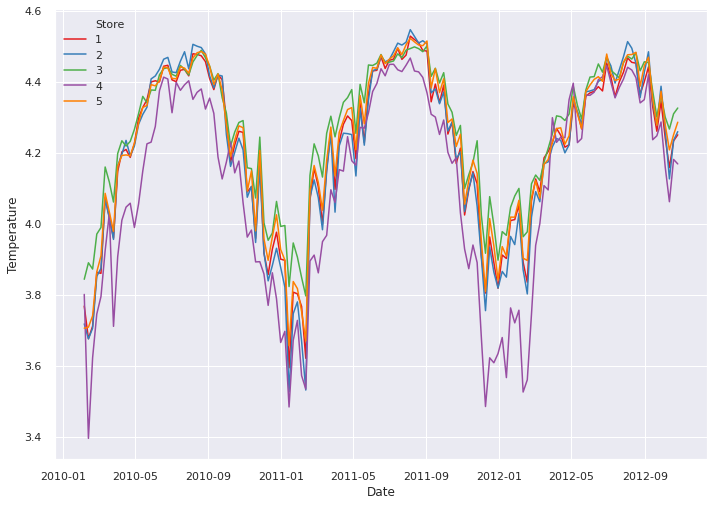

In [41]:
# Weekly_sales vs predictors 

sns.lineplot(data=sample_train, x=sample_train.index, y='Temperature',hue='Store',palette="Set1")

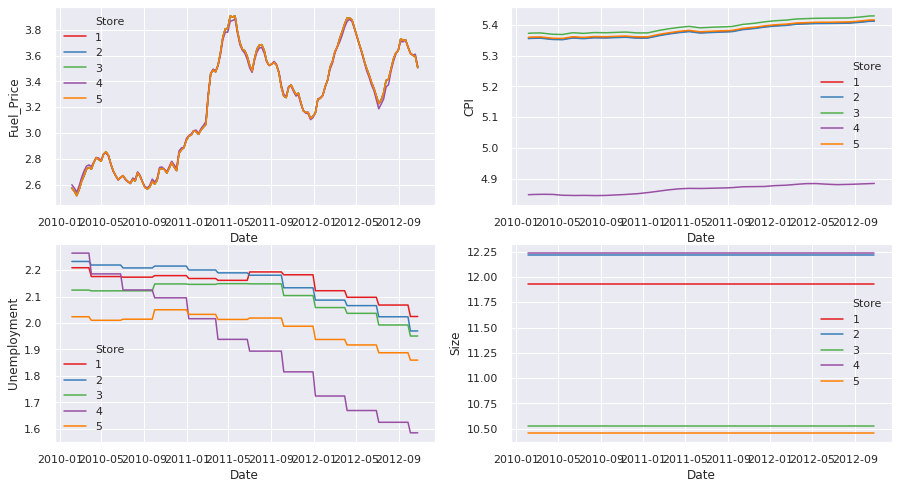

In [42]:
fig, axes = plt.subplots(2,2,figsize=(15,8))
ax1, ax2, ax3, ax4 = axes.flatten()

sns.lineplot(data=sample_train, x=sample_train.index, y='Fuel_Price',hue='Store',palette="Set1",ax=ax1)
sns.lineplot(data=sample_train, x=sample_train.index, y='CPI',hue='Store',palette="Set1",ax=ax2)
sns.lineplot(data=sample_train, x=sample_train.index, y='Unemployment',hue='Store',palette="Set1",ax=ax3)
sns.lineplot(data=sample_train, x=sample_train.index, y='Size',hue='Store',palette="Set1",ax=ax4)

# ax2.set_ylabel("CPI") 
plt.show()

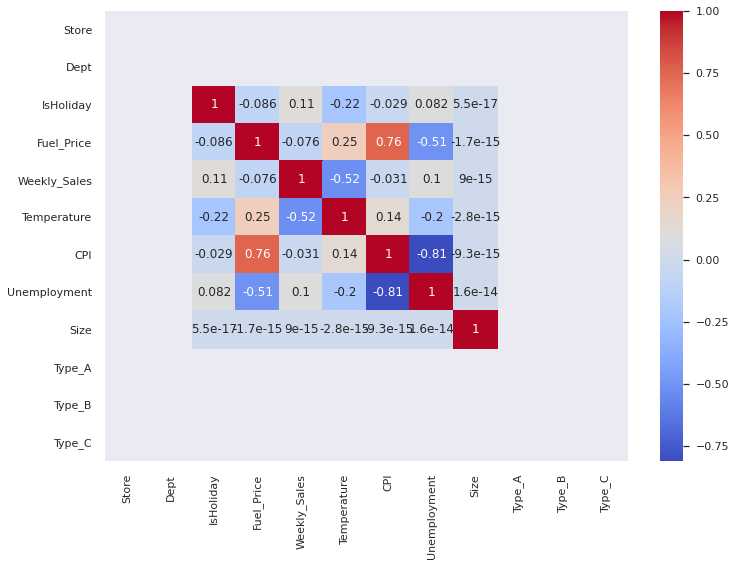

In [43]:
# correlation between predictors
temp_df = sample_train.loc[(sample_train.Store==1)& (sample_train.Dept==1)]
dcorr = temp_df.corr()
sns.heatmap(dcorr,cmap="coolwarm",annot=True)

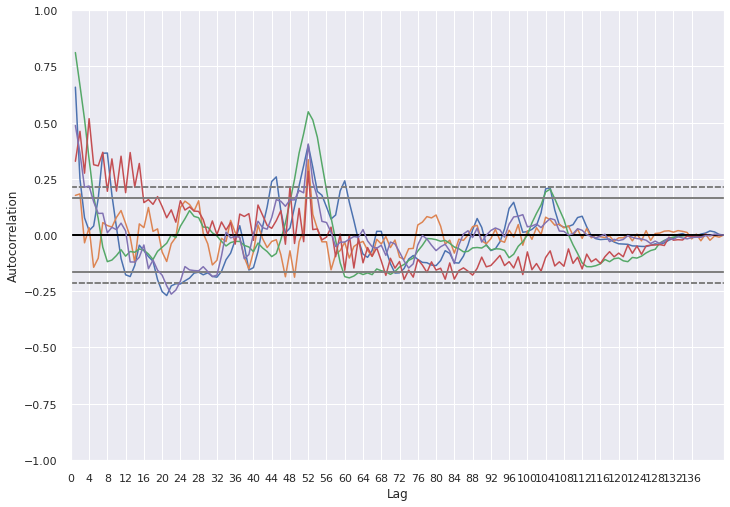

In [44]:
# autocorrelation plot of 'Weekly_sales'
from pandas.plotting import autocorrelation_plot

for row in sample_sid_did:
    weekly_sales = rtrain.loc[(rtrain.Store==row[0]) & (rtrain.Dept==row[1]),'Weekly_Sales']
#     weekly_sales = weekly_sales.diff()
#     weekly_sales.dropna(inplace=True)
    ax = autocorrelation_plot(weekly_sales)
    ax.set_xticks(np.arange(0, 140, 4))
plt.grid()
plt.show()

As we can see at lag-52 we have lot of correlation for majority of timeseries. So we use it to remove the seasonality. (plot mark: plot_02)

In [45]:
# lets check the trend and seasonality of the sample data using seasonal_decompose



# EDA conclusion

* 'Temperature' column has strong seasonality
* 'Fuel_Price' column has both trend and seasonality
* rest of the columns seems stationary 
* 'Weekly_sales' has strong seasonality at lag52. 
* 

# Time-series Analysis and Modelling

## Time-series Analysis

We will apply following tests to check the stationarity and apply some transformations to make it stationary.

* Stationarity Test
    * ADF
    

## Modelling

We will try different models to train/test the data and compare the results. <br>
So lets start with basic to complex. <br>
Once done with all the models, lets use mix of models (weighted forecast of models).

Following models are used in the order: <br>

1. SARIMA
    * This algo needs 'Weekly_sales' and it doesn't use other predictors to forecast. So we should put this model accuracy as min-threshold.
    * There is strong seasonality in the 'Weekly_sales' data. So we used SARIMA (Not ARIMA)
    * 
2. SARIMAX
    * This algo considers exogeneous (external) variables to forecast.
    * 
3. Random Forest and Gradient boosting
    * These are more general models (unlike ARIMA models). These models use predictors to forecast 'Weekly_sales'. So we make this model accuracy as min-threshold for more advanced models such as 'VAR' and 'Multi-linear regression model with ARIMA'
    * 
4. VAR (vector auto regression)
    * This model uses all the predictors and Target.
    * This model's assumption is "every predictor is dependent on every other predictor"
    * 
5. Multi-linear regression model with ARIMA

6. Mix of multiple models
    * select best 2,3 models and avg their result to forecast.
    * This is basically done to reduce over-fitting. 

In [46]:
# ADF test to check the stationarity of sample data

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

for row in sample_sid_did:
    sid=row[0]
    did=row[1]
    weekly_sales = sample_train.loc[(sample_train.Store==sid)& (sample_train.Dept==did)].Weekly_Sales
    result = adfuller(weekly_sales,autolag='AIC')
    print ("store="+str(sid)+", deptid="+str(did))
    print ('ADF statistic: %f' % result[0])
    print ('p-value: %f'%result[1])
    print ('critical values')
    for key, val in result[4].items():
        print ('\t%s: %.3f'%(key,val))

    if (result[0]<result[4]['5%']):
        print ("----> TS is stationary")
    else:
        print ("----> TS is not stationary")

/opt/conda/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/opt/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


store=1, deptid=1
ADF statistic: -3.061502
p-value: 0.029537
critical values
	1%: -3.481
	5%: -2.884
	10%: -2.579
----> TS is stationary
store=2, deptid=2
ADF statistic: -6.422962
p-value: 0.000000
critical values
	1%: -3.478
	5%: -2.882
	10%: -2.578
----> TS is stationary
store=3, deptid=3
ADF statistic: -3.454310
p-value: 0.009241
critical values
	1%: -3.481
	5%: -2.884
	10%: -2.579
----> TS is stationary
store=4, deptid=4
ADF statistic: -1.952268
p-value: 0.307886
critical values
	1%: -3.480
	5%: -2.883
	10%: -2.578
----> TS is not stationary
store=5, deptid=5
ADF statistic: -5.115705
p-value: 0.000013
critical values
	1%: -3.478
	5%: -2.882
	10%: -2.578
----> TS is stationary


some time series are stationary and some are not. So, lets make them all stationary by removing the seasonality that we discovered in plot_02 (autocorrelation plot)

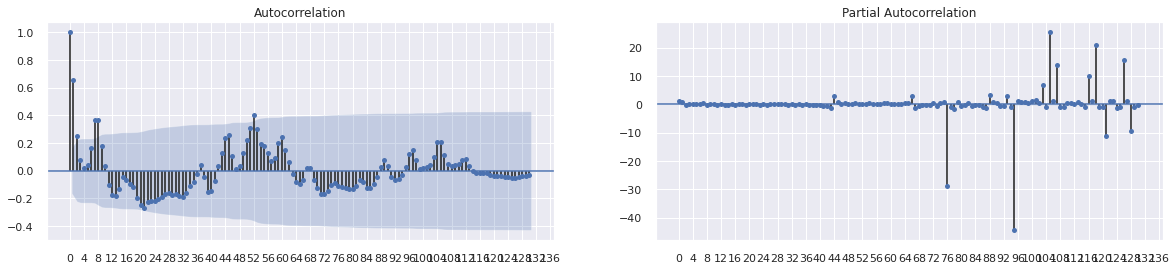

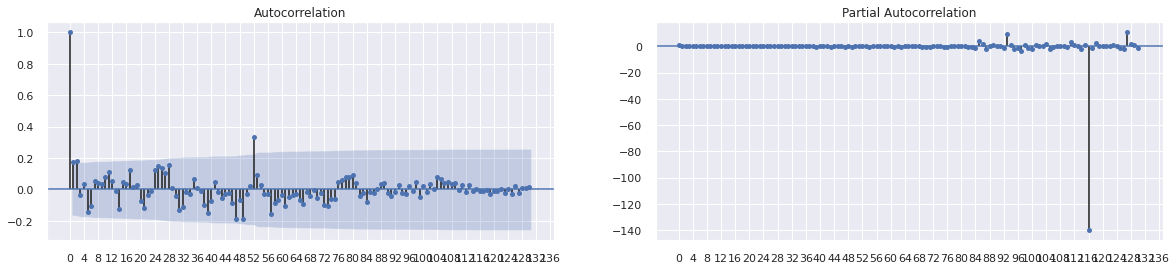

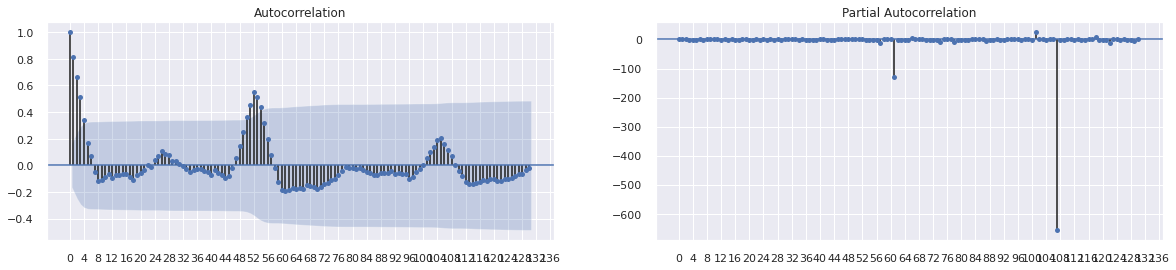

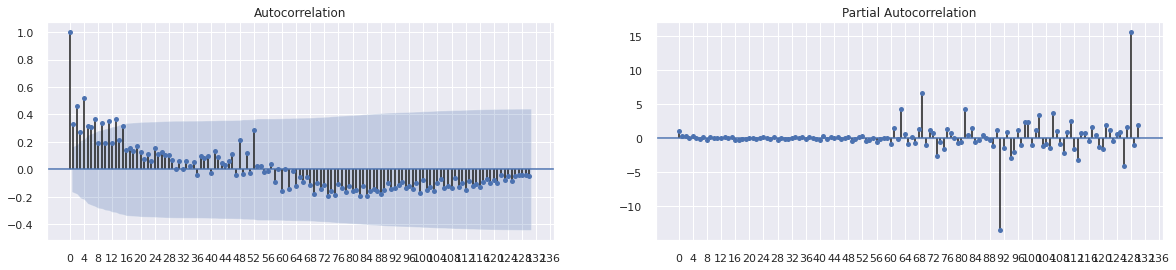

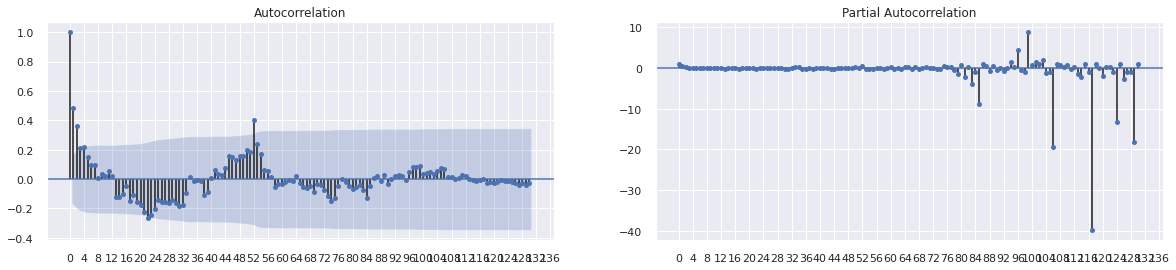

In [47]:
# acf and pcaf on original data.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings(action='ignore')
numlags=130
for row in sample_sid_did:
    sid=row[0]
    did=row[1]
    weekly_sales = sample_train.loc[(sample_train.Store==sid)& (sample_train.Dept==did)].Weekly_Sales
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,4))
#     ax1.plot(weekly_sales);
    plot_acf(weekly_sales, ax=ax1,lags=numlags)
    ax1.set_xticks(np.arange(0, 140, 4))
    ax2.set_xticks(np.arange(0, 140, 4))
    plot_pacf(weekly_sales, ax=ax2,lags=numlags)
    plt.show()

warnings.filterwarnings(action='once')

* acf, pacf isn't providing much information as time series is not stationary.
* lets take a lag1 and check the stationarity of the time series.

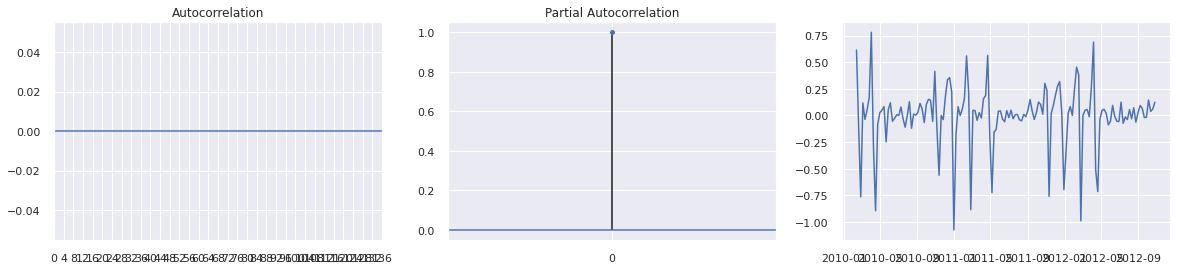

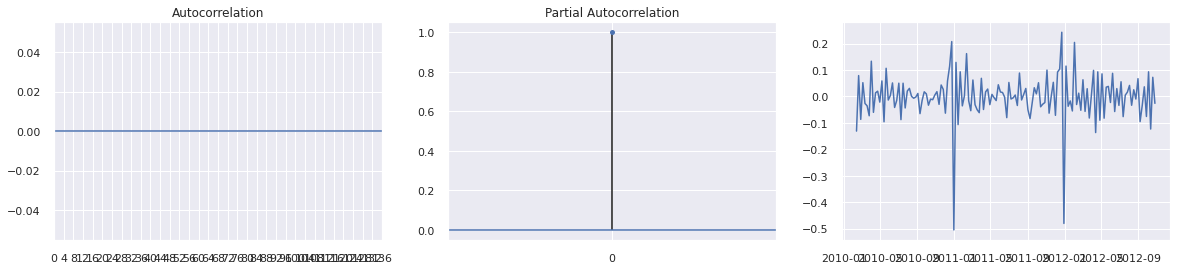

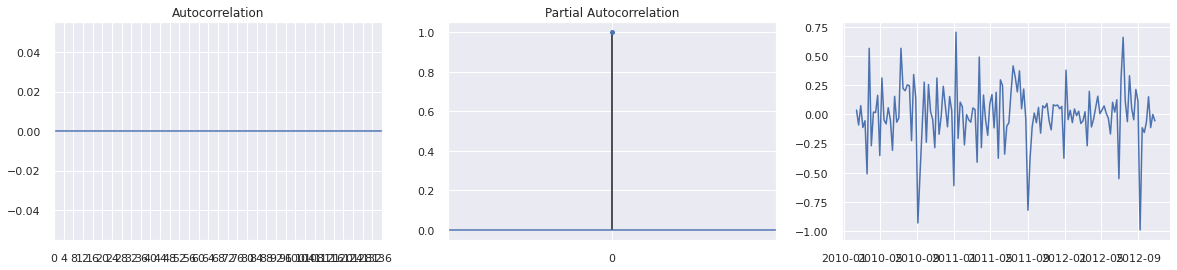

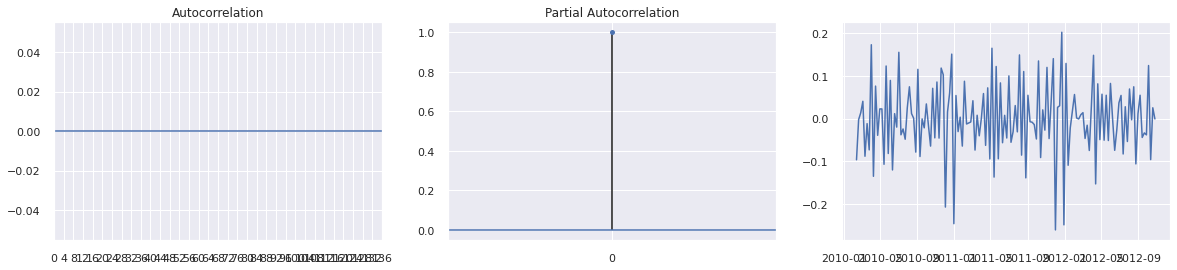

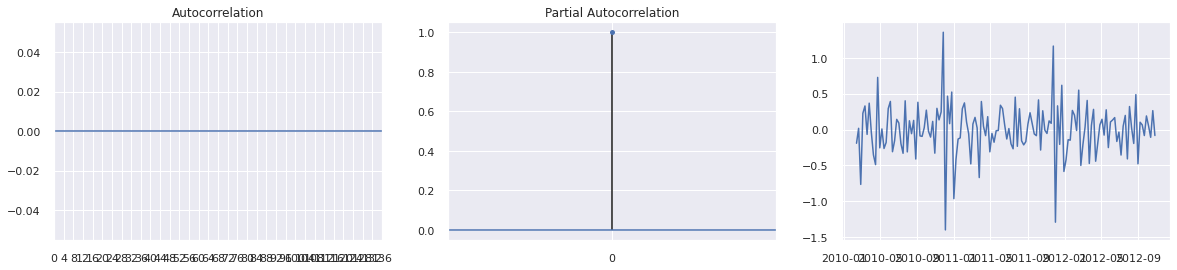

In [48]:
# lag1 acf, pacf plots of timeseries.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

numlags=70
for row in sample_sid_did:
    sid=row[0]
    did=row[1]
    weekly_sales = sample_train.loc[(sample_train.Store==sid)& (sample_train.Dept==did)].Weekly_Sales
    weekly_sales = weekly_sales.diff()
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(20,4))
    ax3.plot(weekly_sales);
    plot_acf(weekly_sales, ax=ax1,lags=numlags)
    ax1.set_xticks(np.arange(0, 140, 4))
    ax2.set_xticks(np.arange(0, 140, 4))
    plot_pacf(weekly_sales, ax=ax2,lags=numlags)
    plt.show()

In [49]:

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
i=0
itr_gp = pd.DataFrame(rtest.groupby(['Store','Dept']))
sample_stores = itr_gp[0]
tmp_list = []
error_cnt=0
sample_count=200
for row in sample_stores:
    if (i==sample_count):
        break
    i=i+1
    sid=row[0]
    did=row[1]
    weekly_sales = rtrain.loc[(rtrain.Store==sid)& (rtrain.Dept==did)].Weekly_Sales
    weekly_sales = weekly_sales.diff()
    weekly_sales = weekly_sales.dropna()
    try:
        result = adfuller(weekly_sales,autolag='AIC')
    except:
        error_cnt=error_cnt+1
        continue
#     print ("store="+str(sid)+", deptid="+str(did))
#     print ('ADF statistic: %f' % result[0])
#     print ('p-value: %f'%result[1])
#     print ('critical values')
#     for key, val in result[4].items():
#         print ('\t%s: %.3f'%(key,val))
#     if (result[0]<result[4]['5%']):
#         print ("----> TS is stationary")
#     else:
#         print ("----> TS is not stationary")
    tmp_list.append(result[0]<result[4]['5%'])
    
val = (sum(tmp_list)/(sample_count-error_cnt))
print ("%f percent of samples in %d are stationary"%(val*100,sample_count))

99.497487 percent of samples in 200 are stationary


As lag1 gives almost all the time series models (for each (storeid, deptid)combination). So we will use lag1 in SARIMA model.

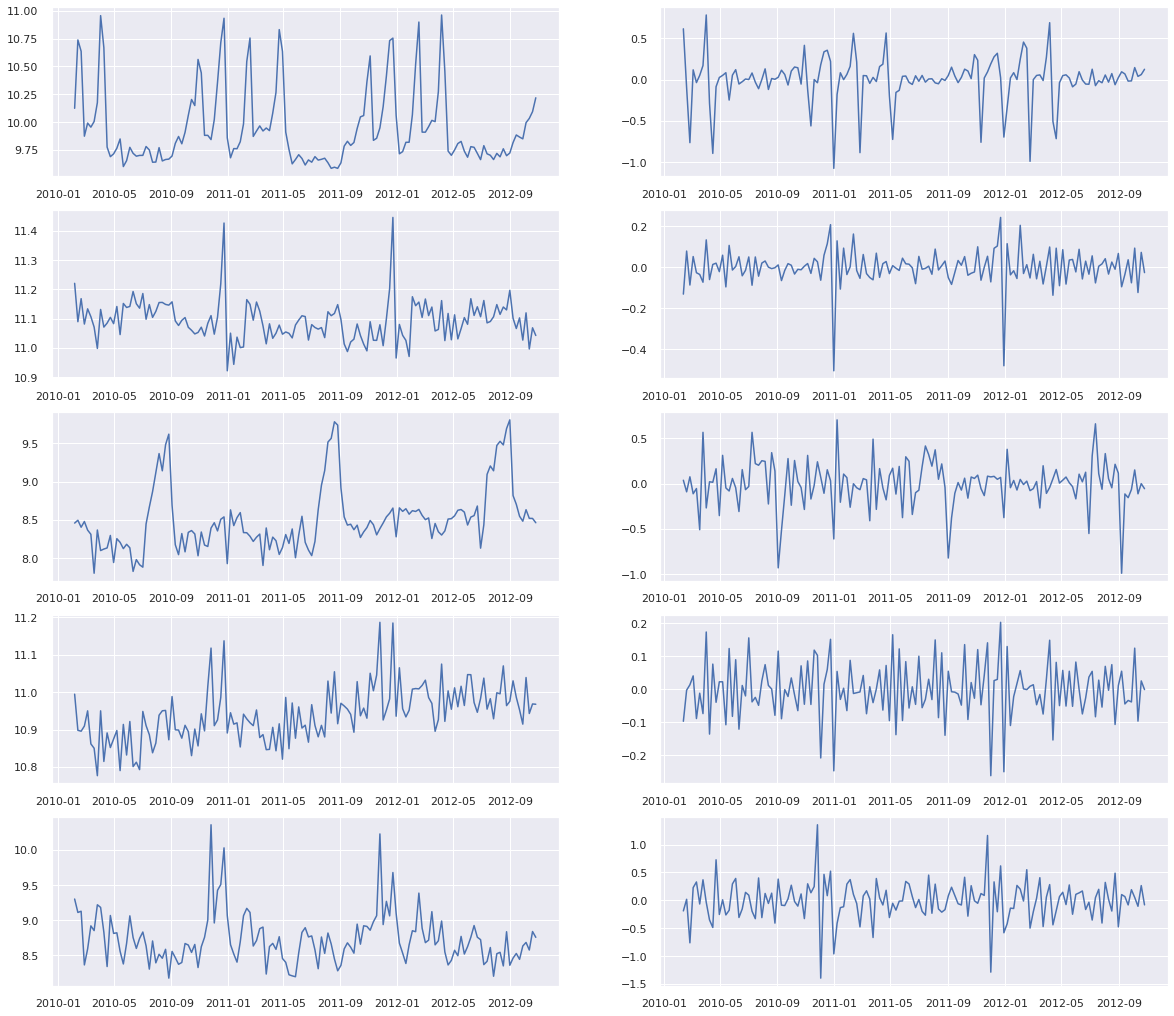

In [50]:
# lets see the graphs of each timeseires and their lag1.

fig, axes = plt.subplots(5,2,figsize=(20,18))

i=0
for row in sample_sid_did:
    sid=row[0]
    did=row[1]
    weekly_sales = rtrain.loc[(rtrain.Store==sid)& (rtrain.Dept==did)].Weekly_Sales
    sns.lineplot(data=weekly_sales, ax=axes[i,0])
    weekly_sales_lag1 = weekly_sales.diff()
    sns.lineplot(data=weekly_sales_lag1, ax=axes[i,1])
    i=i+1
# ax2.set_ylabel("CPI") 
plt.show()

[TODO] Dont know why they are blank. Similarly, their pcf, acf values are also 0. 

below is plot_03

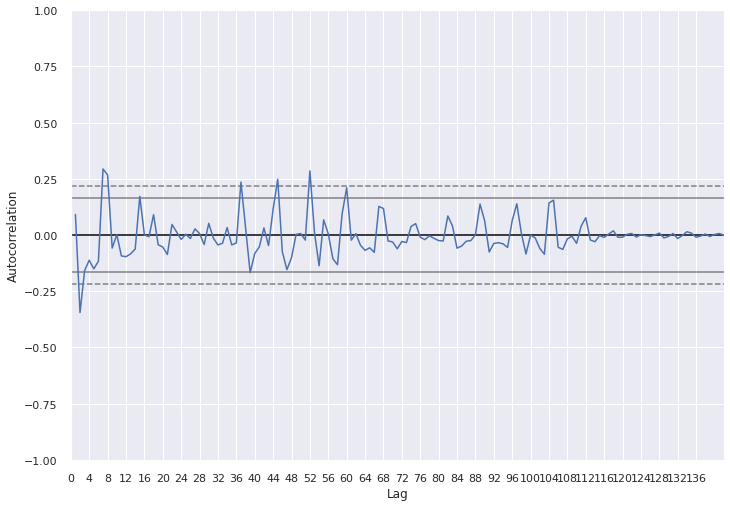

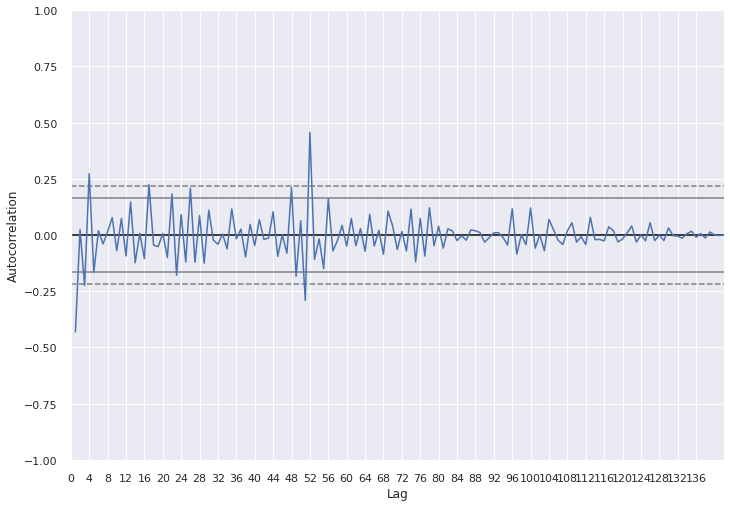

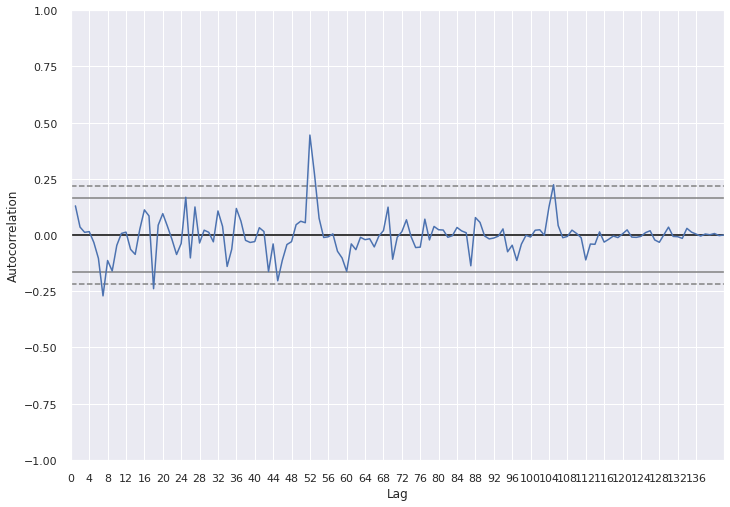

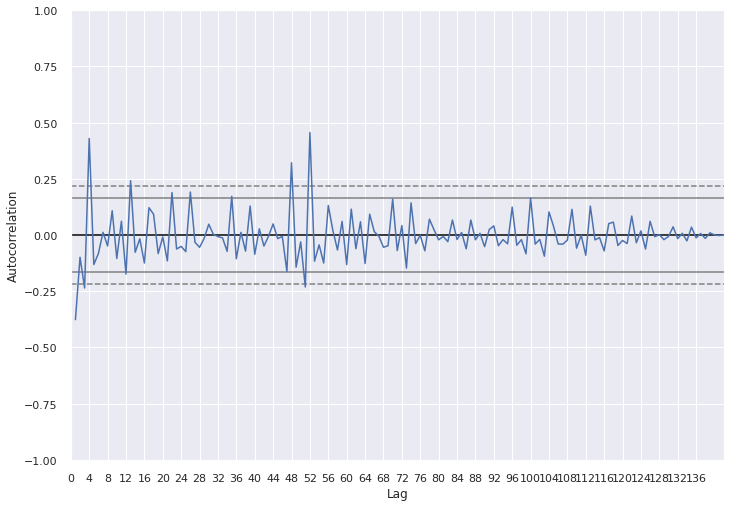

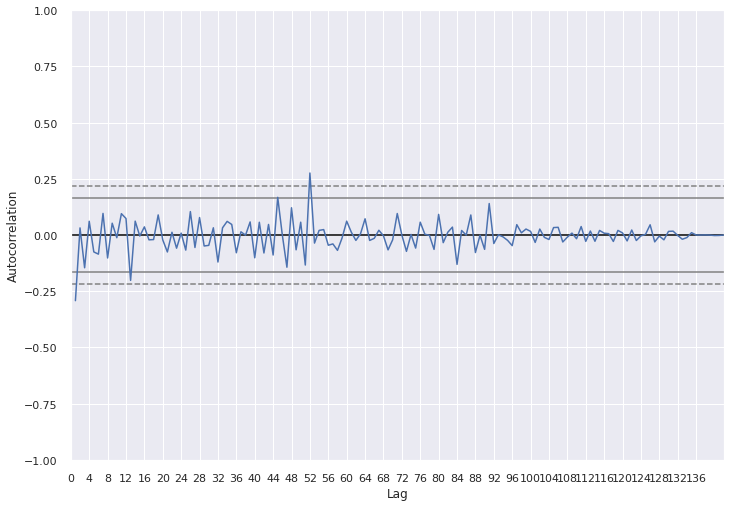

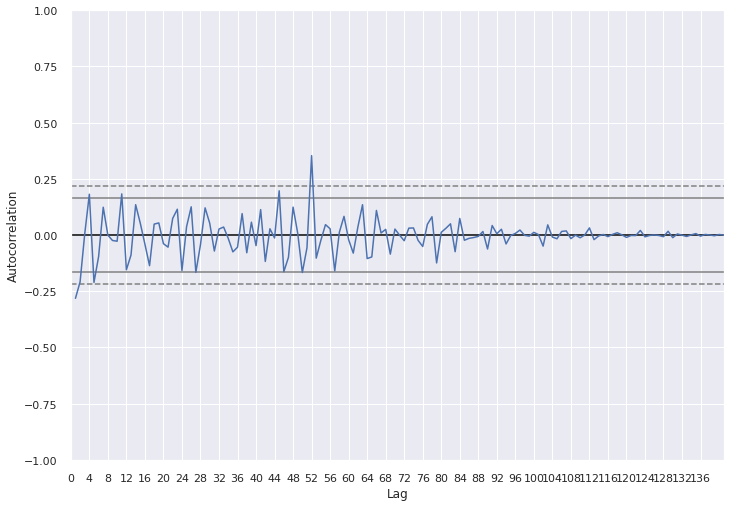

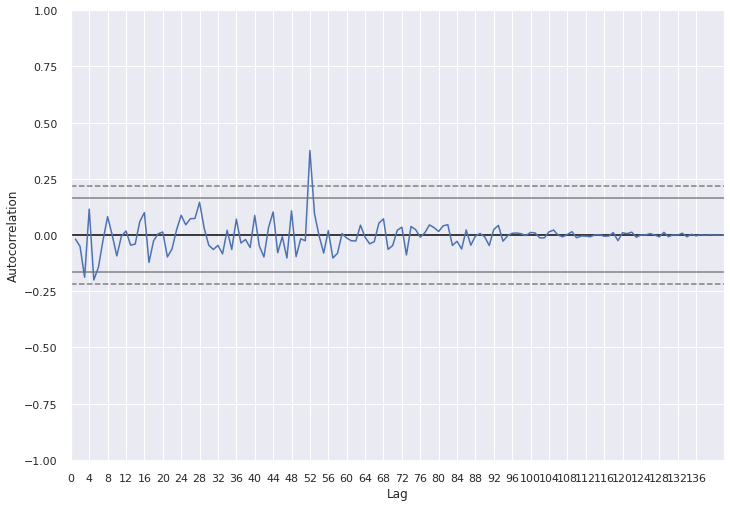

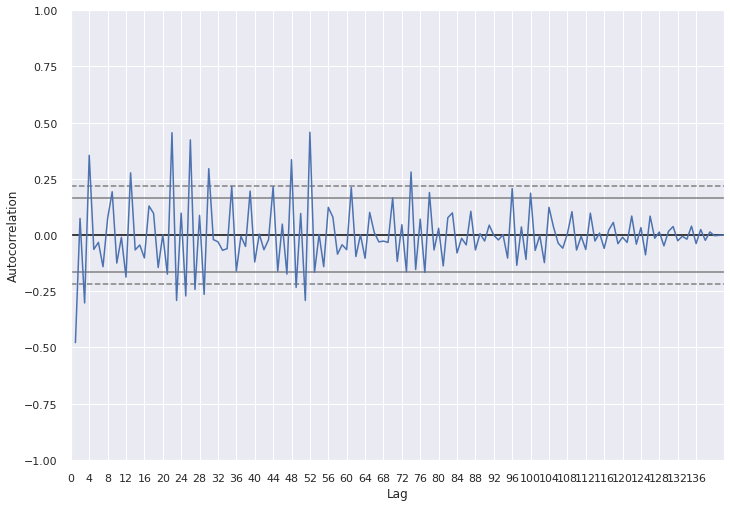

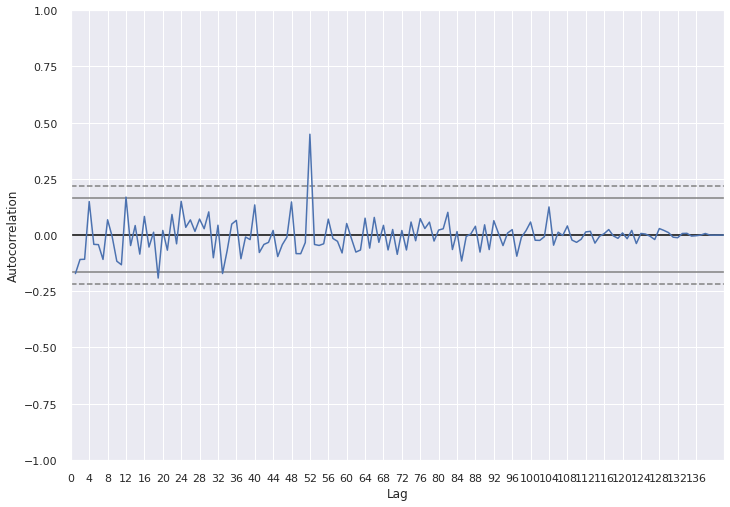

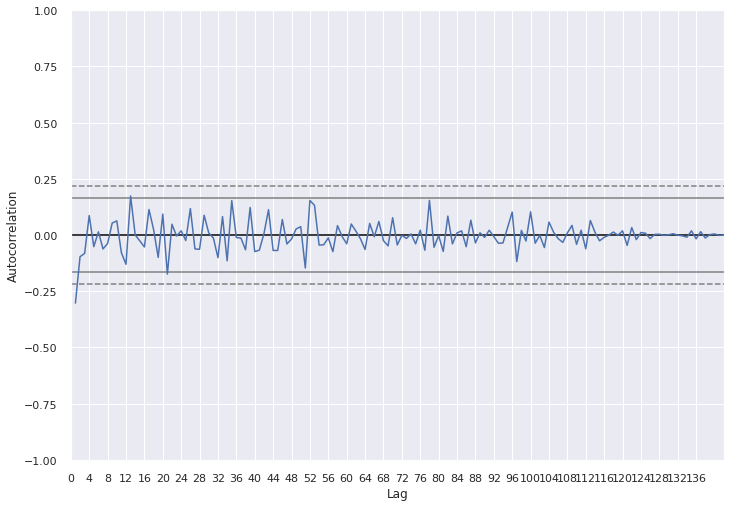

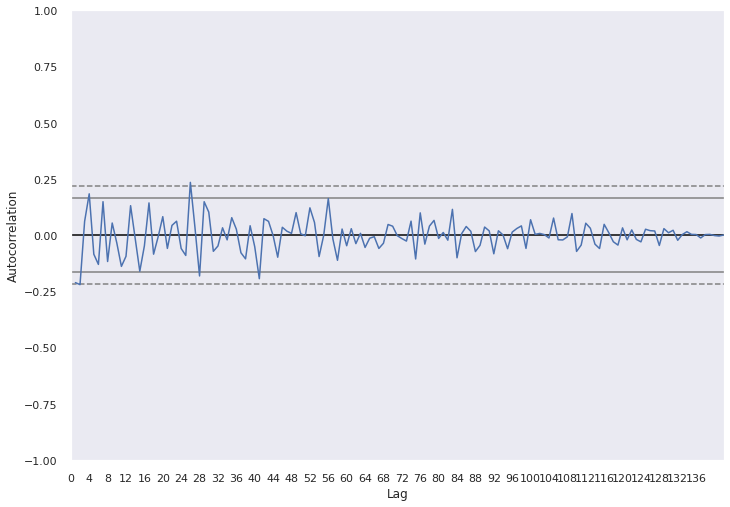

In [51]:
itr_gp = pd.DataFrame(rtest.groupby(['Store','Dept']))
sample_stores = itr_gp[0]
i=0
warnings.filterwarnings(action='ignore')
for row in sample_stores:
    weekly_sales = rtrain.loc[(rtrain.Store==row[0]) & (rtrain.Dept==row[1]),'Weekly_Sales']
    weekly_sales = weekly_sales.diff()
    weekly_sales.dropna(inplace=True)
    ax = autocorrelation_plot(weekly_sales)
    ax.set_xticks(np.arange(0, 140, 4))
    if (i==10):
        break
    i=i+1
    plt.grid()
    plt.show()

warnings.filterwarnings(action='once')

In [52]:
#lets see the data points for depts of each store.
itr_gp = pd.DataFrame(rtest.groupby(['Store','Dept']))
sample_stores = itr_gp[0]
data_points = []
for row in sample_stores:
    cnt = rtrain.loc[(rtrain.Store==row[0]) & (rtrain.Dept==row[1])].Store.count()
    data_points.append(cnt)
data_points = pd.DataFrame(data_points,columns=['points'])

In [53]:
data_points.loc[data_points.points<52]

,points
43,13
73,37
117,14
131,2
148,39
...,...
3073,11
3075,12
3134,0
3139,25


[TODO]I think we can drop those (store, dept) which doesn't have 1 year worth of data observations. <br>
i dont know 

### SARIMAX model

Points considered to apply sarima model: 
* As we already analysed trend, seasonal part of timeseries. we will give that info to sarima model and the original training data(not the differenced one.)
* When we did first diff, trend is gone so (p,d,q)=(0,1,1).
    * This is non-seasonal part of model
* As for seasonal part which is still in train.diff data, 
    * from plot_03 we can clearly see there is 52 week seasonality in most of the time-series. So we use that information.
    * (P,D,Q)m = (1,0,0)52 which means
    * Auto regress to 52 weeks in seasonal model and use 52 weeks data of MA.
    * m=52 means, these many data points per year
    
    
Conclusion:
 
* residuals doesn't show any patterns. so, we can consider the model has learned good amount of information and left little for the residuals. 
* model can be improved very much, so lets try other models.

Result:
* validation score(wmae) = 2683.36 using (p,d,q)=(0,1,1); (P,D,Q)m = (1,0,0)52; train-test-split=0.7
    * submission score with above specs= 

In [54]:
# we are using auto_arima to get best possible values and we cross check them with ours.
# "pip install pmdarima" to install pmdarima using console in kaggle notebook
# import pmdarima as pm
# dont know why it says no module named 'pmdarima' even after installing by pip

# so we use manual sarima model.

In [55]:
# following is the official error prediction formula.
# weighted mean absolute error (weight =5 on holidays)

def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

Following is a manual implementation of one timeseries model with SARIMAX algo where automating it to over 3600 timeseries models is done afterwards. 

In [56]:
# mtrain is 70% data and mvalid is 30%.
mtrain = rtrain['2010-02-05':'2012-02-10']
mvalid = rtrain['2012-02-17':]

In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import time

non_seasonal_order=(0,1,1)
myseasonal_order=(1,0,0,52)
sid=1
did=1
exo_features = ['Store', 'Dept', 'IsHoliday', 'Fuel_Price',
       'Temperature', 'CPI', 'Unemployment', 'Size', 'Type_A', 'Type_B',
       'Type_C']
mtrain_sales = mtrain.loc[(mtrain.Store==sid) & (mtrain.Dept==did),'Weekly_Sales']
mtrain_exo = mtrain.loc[(mtrain.Store==sid) & (mtrain.Dept==did),exo_features]

start_time = time.time()
model = SARIMAX(mtrain_sales,order=non_seasonal_order, seasonal_order=myseasonal_order,
                enforce_stationarity=False, enforce_invertibility=False,exogenous=mtrain_exo)
model_fit = model.fit()
end_time = time.time()
print ('Model fit done in: '+str(end_time-start_time)+" sec")

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


Model fit done in: 1.067237138748169 sec


In [58]:
print (model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                        Weekly_Sales   No. Observations:                  106
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 52)   Log Likelihood                   6.840
Date:                             Sat, 25 Jul 2020   AIC                             -7.679
Time:                                     09:51:42   BIC                             -1.768
Sample:                                 02-05-2010   HQIC                            -5.406
                                      - 02-10-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3671      0.089      4.136      0.000       0.193       0.541
ar.S.L52       0.5302      

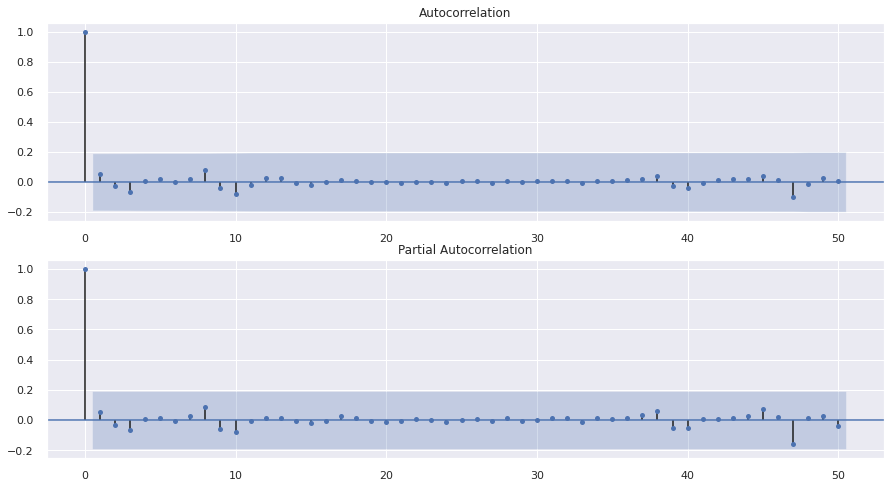

In [59]:
import statsmodels.api as sm
train_resid = model_fit.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(train_resid, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train_resid, lags=50, ax=ax[1])
plt.show()

In [60]:
mvalid_exo = mvalid.loc[(mvalid.Store==sid) & (mvalid.Dept==did),exo_features]
mvalid_actual_result = mvalid.loc[(mvalid.Store==sid) & (mvalid.Dept==did),'Weekly_Sales']
forecast_vals = model_fit.predict(start='2012-02-17',end='2012-10-26',exog=mvalid_exo)
predictions = pd.DataFrame(forecast_vals, index=mvalid_exo.index,columns=['pred'])
valid_residuals = mvalid_actual_result - predictions.pred

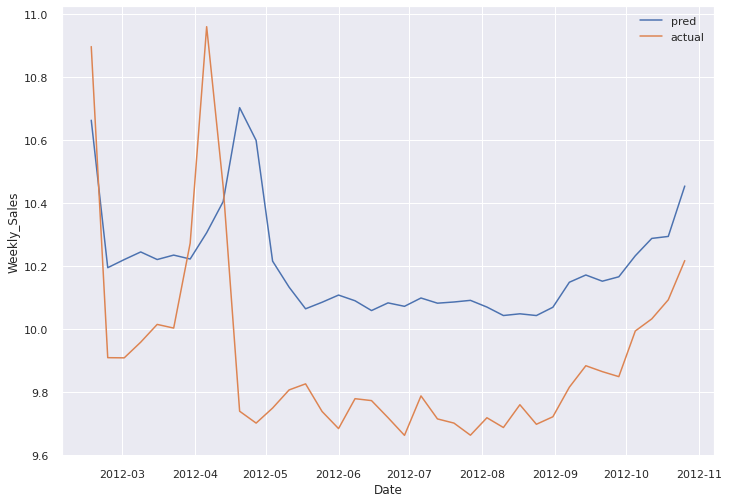

In [61]:
sns.lineplot(y=predictions.pred, x=predictions.index,legend='brief',label='pred')
sns.lineplot(y=mvalid_actual_result,x=predictions.index, legend='brief',label='actual')

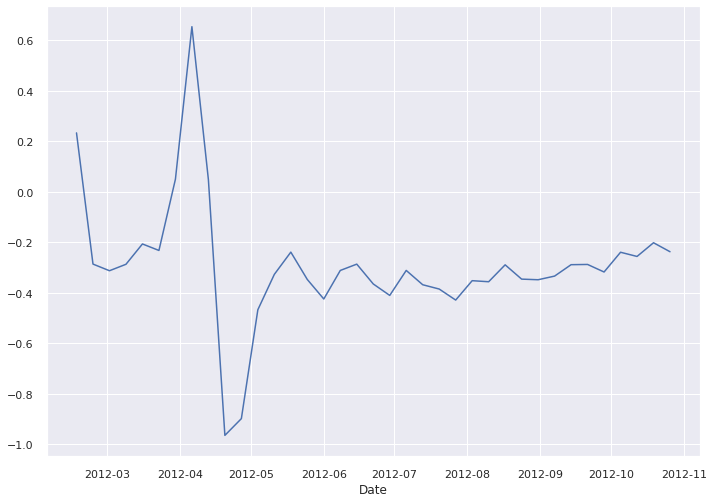

In [62]:
sns.lineplot(y=valid_residuals,x=predictions.index)

In [63]:
val = WMAE(mvalid_exo, real=mvalid_actual_result,predicted=predictions.pred)
val

0.34

In [64]:
# lets create a method to perform modelling for each store, dept combination.
from scipy.special import inv_boxcox

def sarimax_driver(tot_trdata, train_data_pct,ftest=None):
    itr_gp = pd.DataFrame(tot_trdata.groupby(['Store','Dept']))
    all_stores = itr_gp[0]
    exo_features = ['Store', 'Dept', 'IsHoliday', 'Fuel_Price',
           'Temperature', 'CPI', 'Unemployment', 'Size', 'Type_A', 'Type_B',
           'Type_C']
    fresult = pd.DataFrame(columns=['Id','Weekly_Sales'])
    val_result = pd.DataFrame(columns=['sales','Store','Dept'])
    val_result.index.names = ['Date']
    i=0
    for row in all_stores:
        sid = row[0]
        did = row[1]
#         if (i==10):
#             break
#         i+=1
#         if (not ((sid==1) & (did==51))):
#             continue
        cnt = tot_trdata.loc[(tot_trdata.Store==sid) & (tot_trdata.Dept==did)].Store.count()
        # if there are very less observations(10 which is less than 10% of most of (sid,did)pairs (143)), it is not a good idea to pred
        if (cnt<=10):
            continue
        trcnt = int(cnt*train_data_pct)
        valcnt = cnt - trcnt
        store_data = pd.DataFrame(tot_trdata.loc[(tot_trdata.Store==sid) & (tot_trdata.Dept==did)])
        trdata = store_data[0:trcnt]
        valdata = store_data[trcnt:].copy()
        trsales = trdata.Weekly_Sales
        trexo = trdata[exo_features]
        if (ftest is None):
#             print (str(sid)+" "+str(did)+"\t",end="")
            valexo = valdata[exo_features]
            # since some of observations are missing in the validation data. We can not use datetime in start, end. we have to use start, end row number.
#             start_row= valdata.index[0].strftime('%Y-%m-%d')
#             end_row = valdata.index[len(valdata)-1].strftime('%Y-%m-%d')
            start_row = trcnt
            end_row = cnt-1
            predictions = sarimax_specific(trsales, trexo, valexo, start_row, end_row)
            if (predictions is None):
                print ("Exception in train/val (sid, did)"+str(sid)+" "+str(did))
                continue
            preds = pd.DataFrame(data=predictions, columns=['sales'])
            preds.index.names = ['Date']
            valindex = valdata.index
            predictions = preds.copy()
            predictions.loc[:,'sales'] = inv_boxcox(predictions['sales'],0)
            valdata.loc[:,'Weekly_Sales'] = inv_boxcox(valdata['Weekly_Sales'],0)
            # following is done to modify number index (for non-periodic validation timseries) to datetime index.
            dtstr = str(predictions.index[0])
            words = dtstr.split("-")
            if (len(words)==1):
                predictions['Date'] = valdata.index
                predictions.set_index('Date',inplace=True)
#             print ("final pred\n",predictions)
            sales_join = pd.DataFrame(pd.merge(valdata['Weekly_Sales'],predictions['sales'],left_index=True,right_index=True))
            store_result = pd.DataFrame(predictions)
            store_result['Store'] = sid
            store_result['Dept'] = did
            store_result['Weekly_Sales'] = sales_join['Weekly_Sales']
            store_result['IsHoliday'] = valdata['IsHoliday']
            val_result = val_result.append(store_result,ignore_index=True)
            
        else:
            test_exo = ftest.loc[(ftest.Store==sid) & (ftest.Dept==did), exo_features]
            test_cnt = len(test_exo)
            # some of the store, deptid are present in train data but not in test data.
            if (test_cnt==0):
                continue
            start_row = trcnt
            end_row = trcnt+test_cnt-1
            predictions = sarimax_specific(trsales, trexo, test_exo, start_row, end_row)
            if (predictions is None):
                print ("Exception in train/test (sid, did)"+str(sid)+" "+str(did))
                continue
            predictions = inv_boxcox(predictions,0)
            preds = pd.DataFrame(predictions, columns=['Weekly_Sales'])
            preds = preds.reset_index()
            test_date = pd.DataFrame(test_exo.index.strftime('%Y-%m-%d'))
            test_date['Date'] = str(sid)+"_"+str(did)+"_"+test_date['Date']
            test_date.rename(columns={'Date':'Id'},inplace=True)
            test_date['Weekly_Sales'] = preds['Weekly_Sales']
#             print ("final result\n",test_date.head())
            fresult = fresult.append(test_date,ignore_index=True)     
            
    if (ftest is None):
        return pd.DataFrame(val_result)
    else:
        return fresult
            

def sarimax_specific(trsales, trexo, test_exo, start_row, end_row):
    non_seasonal_order=(0,1,1)
    myseasonal_order=(1,0,0,52)
    try:
        model = SARIMAX(trsales,order=non_seasonal_order, seasonal_order=myseasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False,exogenous=trexo)
        model_fit = model.fit()
        predictions = model_fit.predict(start=start_row,end=end_row,exog=test_exo)
    except Exception as e:
        print (e)
        predictions = None
    return predictions


In [65]:
# training and validation of all the timeseries models
import time

warnings.filterwarnings(action='ignore')
t_start = time.time()
fresult = sarimax_driver(rtrain,0.7)
t_end = time.time()
print ("training and validation completed in "+str((t_end-t_start)/60)+" mins")
warnings.filterwarnings(action='once')

training and validation completed in 70.70199070771535 mins


In [66]:
# there are still some null Weekly_sales rows(108 out of 0.4 million rows). so we are going to drop them.

val = len (fresult.loc[fresult.Weekly_Sales.isnull()])
print ("Null value rows count: "+str(val))
fresult.dropna(inplace=True)
val = WMAE(fresult,real=fresult['Weekly_Sales'],predicted=fresult['sales'])
print ("Validation score on all the timeseries models: "+ str(val))

Null value rows count: 108
Validation score on all the timeseries models: 2683.33


In [67]:
# forecasting final test data
import time

warnings.filterwarnings(action='ignore')
t_start = time.time()
fresult = sarimax_driver(rtrain,1,rtest)
t_end = time.time()
print ("training and validation completed in "+str((t_end-t_start)/60)+" mins")
warnings.filterwarnings(action='once')

training and validation completed in 79.9536590496699 mins


In [68]:
print (fresult.loc[fresult.Weekly_Sales.isnull()])
print (len(fresult))

Empty DataFrame
Columns: [Id, Weekly_Sales]
Index: []
114706


In [69]:
# Evaluation Exception: Submission must have 115064 rows
# we have 114706 rows. We are not forecasting some of the sid_did pairs which has too less data (<10 rows, sometimes 0 rows of training data(10,99);)
# so lets add them with 0 value.

sample_sub = pd.DataFrame(pd.read_csv('/kaggle/working/sampleSubmission.csv')) #,parse_dates=[2],index_col=2,squeeze=True))
sample_sub_set = set(sample_sub['Id'])
sub_set = set(fresult["Id"])
diff_set = sample_sub_set.difference(sub_set)
diff_list = list (diff_set)
diff_df = pd.DataFrame()
diff_df['Id'] = diff_list
diff_df['Weekly_Sales'] = 0
diff_df

,Id,Weekly_Sales
0,32_47_2012-11-02,0
1,12_99_2013-07-12,0
2,37_29_2013-02-08,0
3,36_33_2012-12-14,0
4,18_99_2012-11-30,0
...,...,...
353,12_99_2012-12-14,0
354,9_99_2012-12-07,0
355,33_49_2013-05-03,0
356,19_39_2013-06-28,0


In [70]:
fresult = fresult.append(diff_df, ignore_index=True)

In [71]:
len(fresult)

115064

In [72]:
fresult.to_csv("/kaggle/working/sarimax_basic.csv",index=False)